In [1]:
import os
import sys
sys.path.extend(["../..", "."])

from nebula.misc import get_path
SCRIPT_PATH = get_path(type="notebook")
REPO_ROOT = os.path.join(SCRIPT_PATH, "..", "..")

from nebula.evaluation import read_cv_data_splits, read_cv_metrics_folder
from nebula.evaluation.roc import allign_metrics, report_alligned_metrics, get_roc, get_preds
from nebula.misc.plots import plot_roc_curve, plot_cv_metrics_dict
from nebula.models.neurlux import NeurLuxModel
from nebula.models.quovadis import QuoVadisModel
from nebula.models import TransformerEncoderChunks
from collections import defaultdict
import matplotlib.pyplot as plt
from pandas import read_csv
import numpy as np
import pickle
import json
import torch

RUN_TYPES = ['resolved_apis', 'executed_commands', 'mutexes', 'files', 'keys', 'all']
RUN_NAME = "avast_capa"

INFOLDER = "out_avast_fields"

RUN_END_FILTER = "r1763_t5"
run_folders = [x for x in os.listdir(INFOLDER) if x.startswith("cv") and x.endswith(RUN_END_FILTER)]

VOCAB = int(3e4)
SEQ_LEN = 512
LIMIT = "full"
# TBD -- see:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

label_file = os.path.join(REPO_ROOT, r"data\data_raw\Avast\Public_Avast_CTU_CAPEv2_Dataset_Small\public_labels.csv")
LABEL_DF = read_csv(label_file)

LABEL_FIELD = 'classification_family'
LABEL_MAP = dict(zip(
    sorted(LABEL_DF[LABEL_FIELD].unique()),
    list(range(LABEL_DF[LABEL_FIELD].nunique()))
))
REVERSE_LABELMAP = {v: k for k, v in LABEL_MAP.items()}

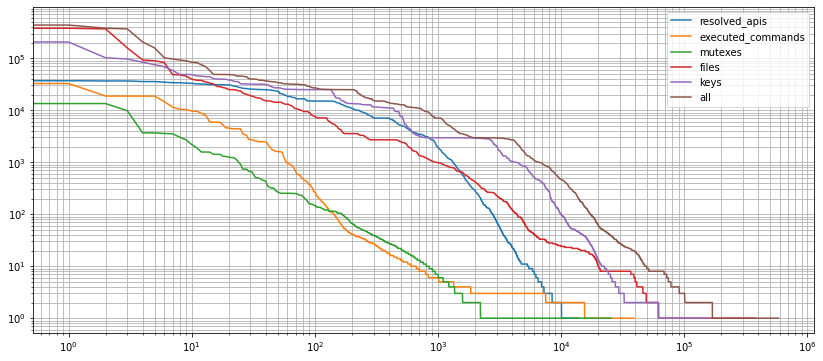

In [2]:
counters = {}

fig, ax = plt.subplots(1,1, figsize=(14,6))

for run_type in RUN_TYPES:
    if run_type == "api_only_full":
        # for some reason "api_only_full" has practically the same token counts as "api_file_network_registry"
        # it might be related to pre-processing that strips all the punctuation?
        # i.e. text = text.translate(str.maketrans('', '', string.punctuation))
        continue
    counter_file = os.path.join(INFOLDER, f"{run_type}_vocab_{VOCAB}_seqlen_{SEQ_LEN}", f"tokenizer_{VOCAB}_counter.json")
    with open(counter_file) as f:
        counter = json.load(f)
    # sort by value
    counter = {k: v for k, v in sorted(counter.items(), key=lambda item: item[1], reverse=True)}
    counters[run_type] = counter
    # plot all token counts
    ax.plot(list(counter.values()), label=run_type)
ax.set_yscale("log")
ax.set_xscale("log")
# scale all ticks
ax.grid(True, which="both")
_ = ax.legend()

In [3]:
models = defaultdict(dict)
for run_type in RUN_TYPES:
    nebula_vocab_file = os.path.join(INFOLDER, f"{run_type}_vocab_{VOCAB}_seqlen_{SEQ_LEN}", f"tokenizer_{VOCAB}_vocab.json")

    with open(nebula_vocab_file) as f:
        nebula_vocab = json.load(f)
    models[run_type]['class'] = TransformerEncoderChunks
    models[run_type]['config'] = {
        "vocab_size": len(nebula_vocab),
        "maxlen": SEQ_LEN,
        "chunk_size": 64,
        "dModel": 64,  # embedding & transformer dimension
        "nHeads": 8,  # number of heads in nn.MultiheadAttention
        "dHidden": 256,  # dimension of the feedforward network model in nn.TransformerEncoder
        "nLayers": 2,  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        "numClasses": 10, # binary classification
        "hiddenNeurons": [64],
        "layerNorm": False,
        "dropout": 0.3,
        "mean_over_sequence": False,
        "norm_first": True
    }
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
metrics_val = defaultdict(list)
model_files = defaultdict(list)
for run_type in RUN_TYPES:
    folder = os.path.join(INFOLDER, f"cv_{run_type}_limNone_{RUN_END_FILTER}")
    key = run_type
    print(f"[*] In process: {key}")

    existing_pickle = os.path.join(INFOLDER, f"{key}_roc_metrics_val_{RUN_END_FILTER}.pkl")
    if os.path.exists(existing_pickle):
        metrics = pickle.load(open(existing_pickle, "rb"))
    else:
        metrics = defaultdict(list)
        data_splits = read_cv_data_splits(folder)
        
        train_folder = os.path.join(folder, "training_files")
        model_files[key] = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if x.endswith(".torch")]
        
        for i, model_file in enumerate(model_files[key]):
            print(f"[*] Running ROC for split: {i}")
            model = models[key]['class'](**models[key]['config']).to(device)
            model.load_state_dict(torch.load(model_file))
            model.eval()
            y_true, y_pred = get_preds(
                model,
                data_splits[i]["X_test"],
                data_splits[i]["y_test"],
                model_name=f"{key}_split_{i}",
                batch_size=96
            )
            y_pred = np.argmax(y_pred, axis=1)
            n_unique_classes = len(np.unique(y_true))
            for n in range(n_unique_classes):
                label = REVERSE_LABELMAP[n]
                y_true_n = np.where(y_true == n, 1, 0)
                y_pred_n = np.where(y_pred == n, 1, 0)
                fpr, tpr, roc_auc, f1, recall, precision, acc = get_roc(y_true_n, y_pred_n, metrics_full=True)
                #print(f"For class {label} metrics are: fpr: {fpr}, tpr: {tpr}, roc_auc: {roc_auc}, f1: {f1}, recall: {recall}, precision: {precision}, acc: {acc}")
                metrics[label].append([fpr, tpr, roc_auc, f1, recall, precision, acc])
        pickle.dump(metrics, open(existing_pickle, "wb"))
    metrics_val[key] = metrics

[*] In process: resolved_apis
[*] Running ROC for split: 0
Evaluating resolved_apis_split_0 | Size: 3087946...


100%|██████████| 137/137 [00:04<00:00, 29.41it/s]


[*] Running ROC for split: 1
Evaluating resolved_apis_split_1 | Size: 3087946...


100%|██████████| 137/137 [00:03<00:00, 34.72it/s]


[*] Running ROC for split: 2
Evaluating resolved_apis_split_2 | Size: 3087946...


100%|██████████| 137/137 [00:03<00:00, 34.52it/s]


[*] In process: executed_commands
[*] Running ROC for split: 0
Evaluating executed_commands_split_0 | Size: 4117834...


100%|██████████| 137/137 [00:03<00:00, 35.15it/s]
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[*] Running ROC for split: 1
Evaluating executed_commands_split_1 | Size: 4117834...


100%|██████████| 137/137 [00:03<00:00, 35.26it/s]
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[*] Running ROC for split: 2
Evaluating executed_commands_split_2 | Size: 4117834...


100%|██████████| 137/137 [00:03<00:00, 34.32it/s]
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[*] In process: mutexes
[*] Running ROC for split: 0
Evaluating mutexes_split_0 | Size: 3823050...


100%|██████████| 137/137 [00:04<00:00, 33.75it/s]
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification

[*] Running ROC for split: 1
Evaluating mutexes_split_1 | Size: 3823050...


100%|██████████| 137/137 [00:04<00:00, 32.78it/s]
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification

[*] Running ROC for split: 2
Evaluating mutexes_split_2 | Size: 3823050...


100%|██████████| 137/137 [00:04<00:00, 31.95it/s]
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification

[*] In process: files
[*] Running ROC for split: 0
Evaluating files_split_0 | Size: 4117834...


100%|██████████| 137/137 [00:04<00:00, 32.61it/s]


[*] Running ROC for split: 1
Evaluating files_split_1 | Size: 4117834...


100%|██████████| 137/137 [00:04<00:00, 33.00it/s]


[*] Running ROC for split: 2
Evaluating files_split_2 | Size: 4117834...


100%|██████████| 137/137 [00:03<00:00, 34.56it/s]


[*] In process: keys
[*] Running ROC for split: 0
Evaluating keys_split_0 | Size: 4117834...


100%|██████████| 137/137 [00:03<00:00, 34.31it/s]


[*] Running ROC for split: 1
Evaluating keys_split_1 | Size: 4117834...


100%|██████████| 137/137 [00:04<00:00, 34.25it/s]


[*] Running ROC for split: 2
Evaluating keys_split_2 | Size: 4117834...


100%|██████████| 137/137 [00:03<00:00, 34.28it/s]


[*] In process: all
[*] Running ROC for split: 0
Evaluating all_split_0 | Size: 4117834...


100%|██████████| 137/137 [00:04<00:00, 33.42it/s]


[*] Running ROC for split: 1
Evaluating all_split_1 | Size: 4117834...


100%|██████████| 137/137 [00:04<00:00, 33.13it/s]


[*] Running ROC for split: 2
Evaluating all_split_2 | Size: 4117834...


100%|██████████| 137/137 [00:04<00:00, 32.24it/s]


Adload
                     0.0001       AUC        F1    Recall  Precision  Accuracy
resolved_apis      0.747413  0.984196  0.980364  0.968495   0.992714  0.999438
executed_commands  0.000100  0.500000  0.000000  0.000000   0.000000  0.985554
mutexes            0.000100  0.500000  0.000000  0.000000   0.000000  0.985554
files              0.270700  0.977530  0.950856  0.955862   0.946667  0.998571
keys               0.410586  0.977717  0.959808  0.955979   0.964378  0.998826
all                0.557797  0.977812  0.966816  0.955936   0.978855  0.999056
Emotet
                     0.0001       AUC        F1    Recall  Precision  Accuracy
resolved_apis      0.014551  0.995362  0.990589  0.997672   0.983612  0.994410
executed_commands  0.004282  0.910272  0.889779  0.841425   0.944208  0.938489
mutexes            0.090759  0.969170  0.967181  0.939859   0.996142  0.981189
files              0.024848  0.979816  0.976712  0.963650   0.990135  0.986447
keys               0.011550  0.988333 

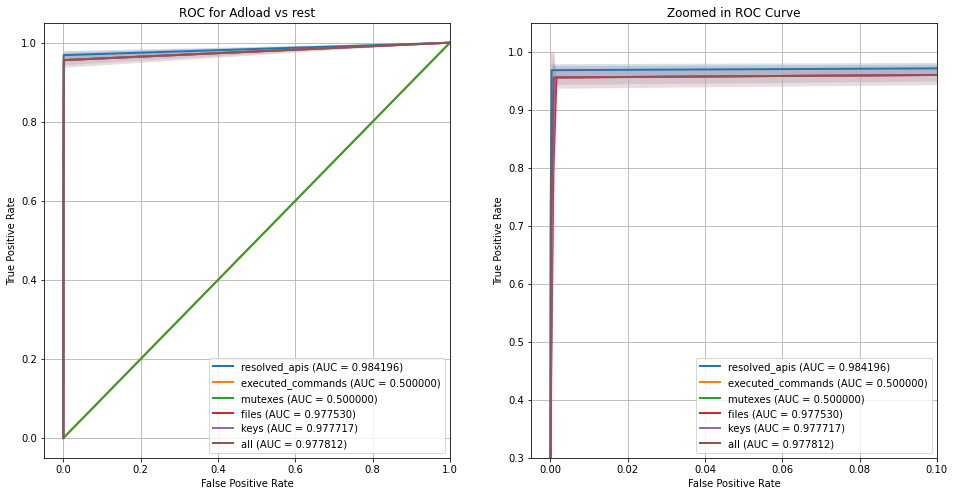

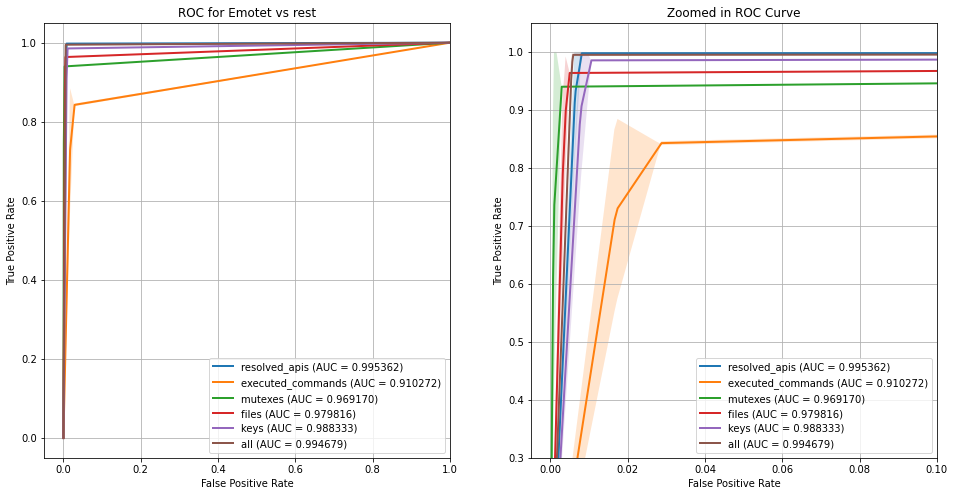

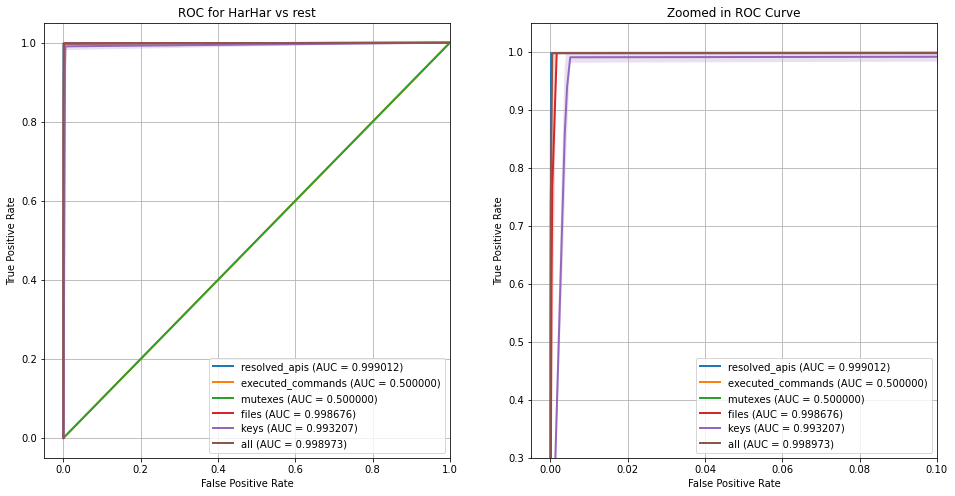

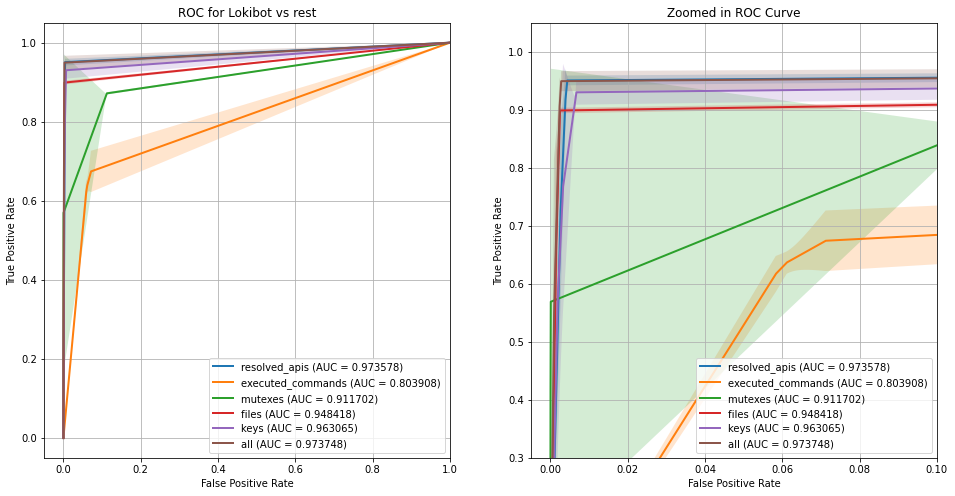

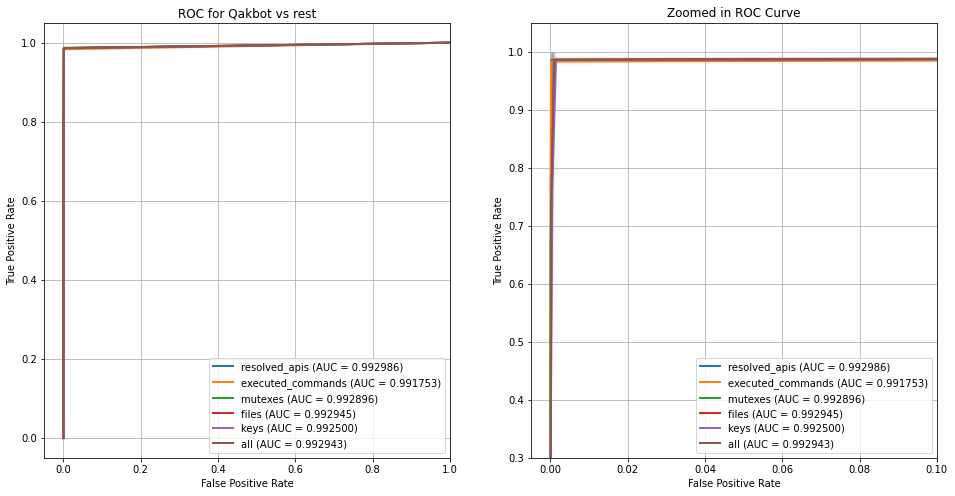

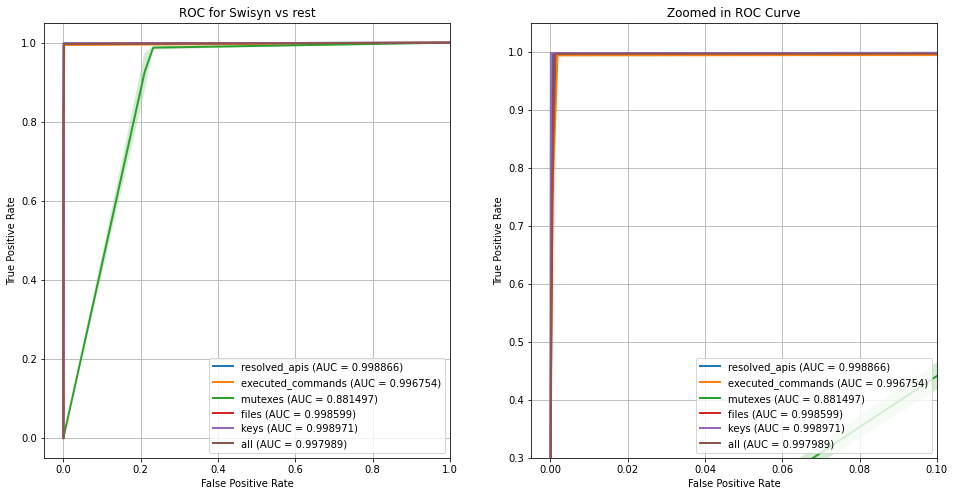

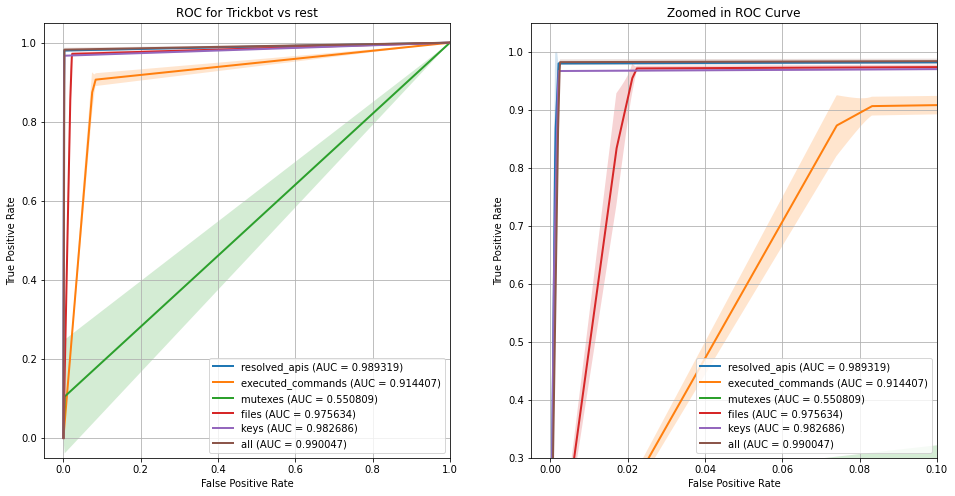

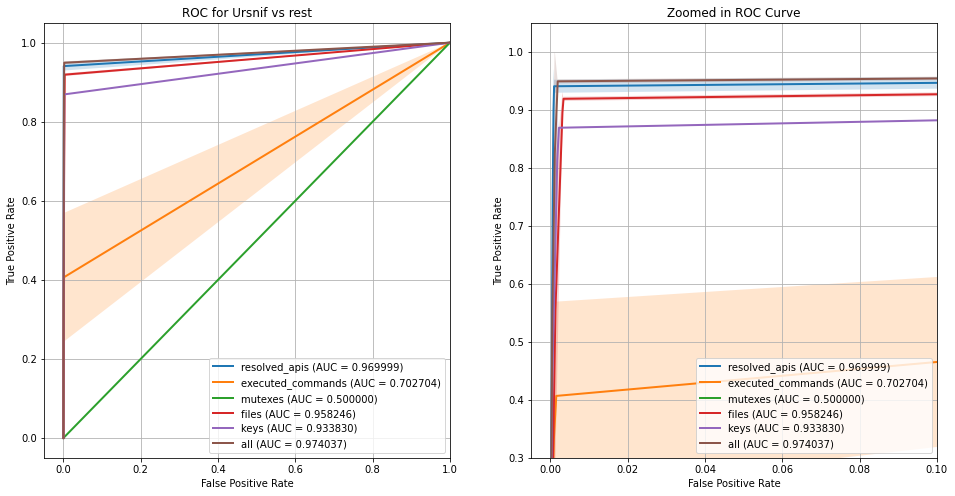

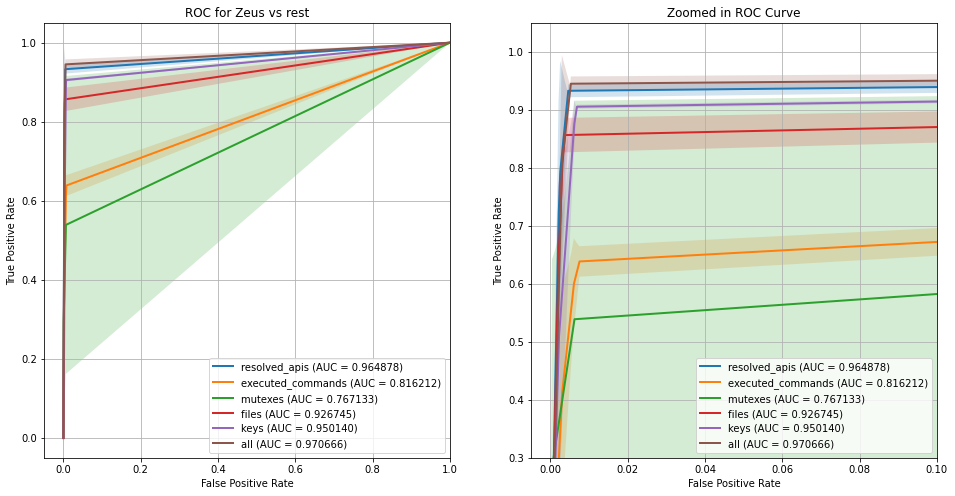

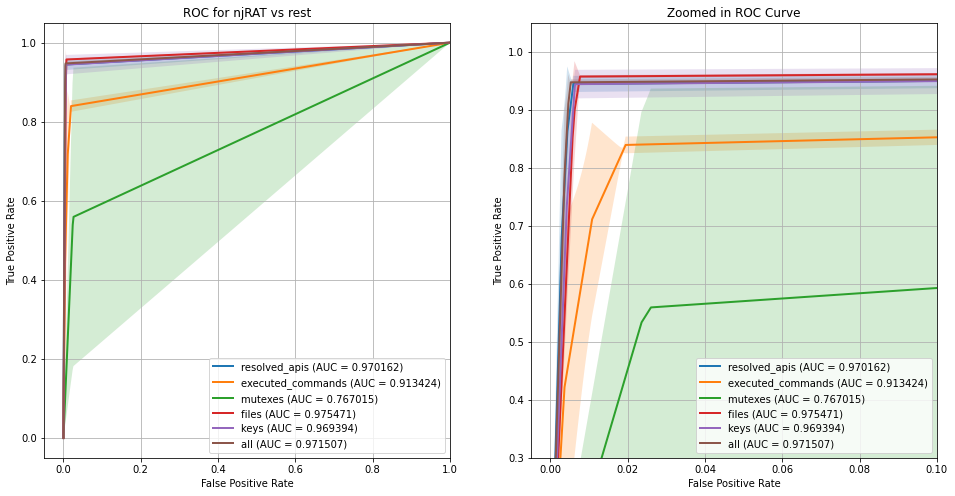

In [5]:
for selected_label in LABEL_MAP.keys():
    metrics_label = {k: v[selected_label] for k, v in metrics_val.items()}
    base_fpr_val, tprs_mean_val, tprs_std_val = allign_metrics(metrics_label)

    df, axs_val = report_alligned_metrics(
        base_fpr_val,
        tprs_mean_val,
        tprs_std_val,
        metrics_label,
        xlim=[-0.005, 0.1],
        ylim=[0.3, 1.05],
        metrics_full=True
    )
    # suptitle to refer label
    axs_val[0].set_title(f"ROC for {selected_label} vs rest")
    print(selected_label)
    print(df[df.columns[0:1].tolist() + df.columns[-5:].tolist()])

## Test set ROCs

In [8]:
metrics_test = defaultdict(list)
model_files = defaultdict(list)
for run_type in RUN_TYPES:
    folder = os.path.join(INFOLDER, f"cv_{run_type}_limNone_{RUN_END_FILTER}")
    key = run_type

    existing_pickle = os.path.join(INFOLDER, f"{key}_roc_metrics_test_{RUN_END_FILTER}.pkl")
    if os.path.exists(existing_pickle):
        metrics = pickle.load(open(existing_pickle, "rb"))
    else:
        metrics = defaultdict(list)
        print(f"[*] In process: {key}")
        
        data_folder = [x for x in os.listdir(INFOLDER) if x.startswith(key) and "vocab" in x][0]
        X_test = np.load(os.path.join(INFOLDER, data_folder, f"x_test_{LIMIT}.npy"))
        y_test = np.load(os.path.join(INFOLDER, data_folder, f"y_test_{LIMIT}.npy"))

        train_folder = os.path.join(folder, "training_files")
        model_files[key] = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if x.endswith(".torch")]

        for i, model_file in enumerate(model_files[key]):
            print(f"[*] Running ROC for split: {i}")
            model = models[key]['class'](**models[key]['config']).to(device)
            model.load_state_dict(torch.load(model_file))
            model.eval()
            y_true, y_pred = get_preds(
                model,
                X_test,
                y_test,
                model_name=f"{key}_split_{i}",
                batch_size=96
            )
            y_pred = np.argmax(y_pred, axis=1)
            n_unique_classes = len(np.unique(y_true))
            for n in range(n_unique_classes):
                label = REVERSE_LABELMAP[n]
                y_true_n = np.where(y_true == n, 1, 0)
                y_pred_n = np.where(y_pred == n, 1, 0)
                fpr, tpr, roc_auc, f1, recall, precision, acc = get_roc(y_true_n, y_pred_n, metrics_full=True)
                #print(f"For class {label} metrics are: fpr: {fpr}, tpr: {tpr}, roc_auc: {roc_auc}, f1: {f1}, recall: {recall}, precision: {precision}, acc: {acc}")
                metrics[label].append([fpr, tpr, roc_auc, f1, recall, precision, acc])
        pickle.dump(metrics, open(existing_pickle, "wb"))
    metrics_test[key] = metrics

Adload
                     0.0001       AUC        F1    Recall  Precision  Accuracy
resolved_apis      0.579713  0.990235  0.983057  0.980676   0.985454  0.999524
executed_commands  0.000100  0.500000  0.000000  0.000000   0.000000  0.985913
mutexes            0.000100  0.500000  0.000000  0.000000   0.000000  0.985913
files              0.277868  0.985110  0.958929  0.971014   0.948325  0.998809
keys               0.299577  0.985283  0.969930  0.971014   0.969019  0.999149
all                0.506812  0.984110  0.971062  0.968599   0.973813  0.999183
Emotet
                     0.0001       AUC        F1    Recall  Precision  Accuracy
resolved_apis      0.016671  0.994840  0.990479  0.995938   0.985092  0.994385
executed_commands  0.003954  0.920190  0.900233  0.862813   0.941141  0.943923
mutexes            0.176511  0.972404  0.970875  0.945915   0.997193  0.983361
files              0.024438  0.981435  0.978168  0.967154   0.989441  0.987342
keys               0.012127  0.990105 

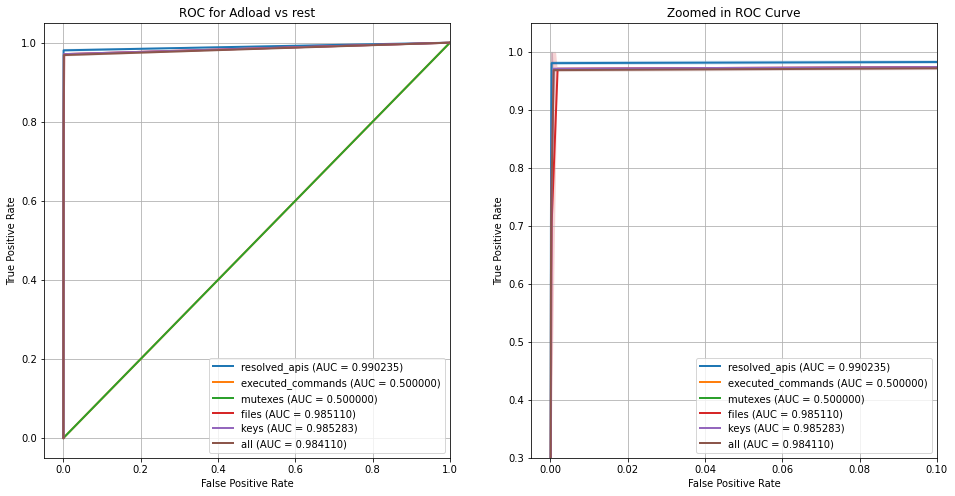

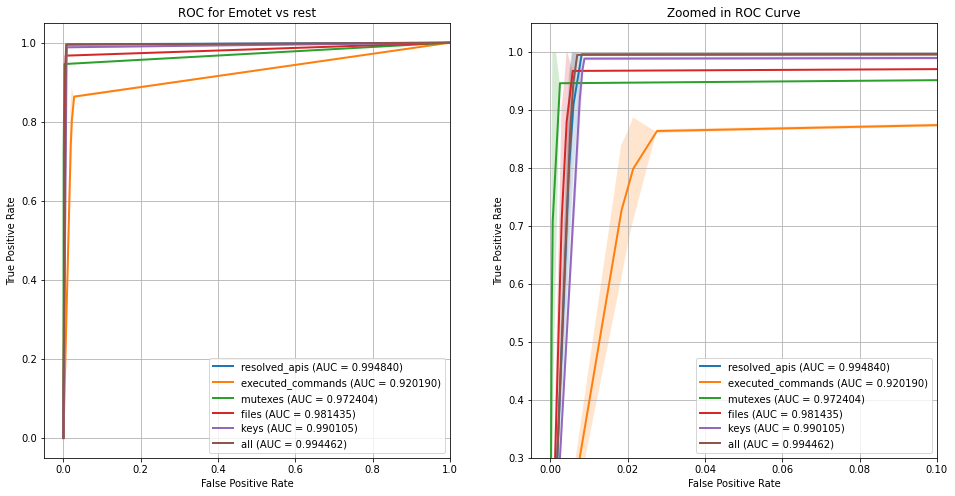

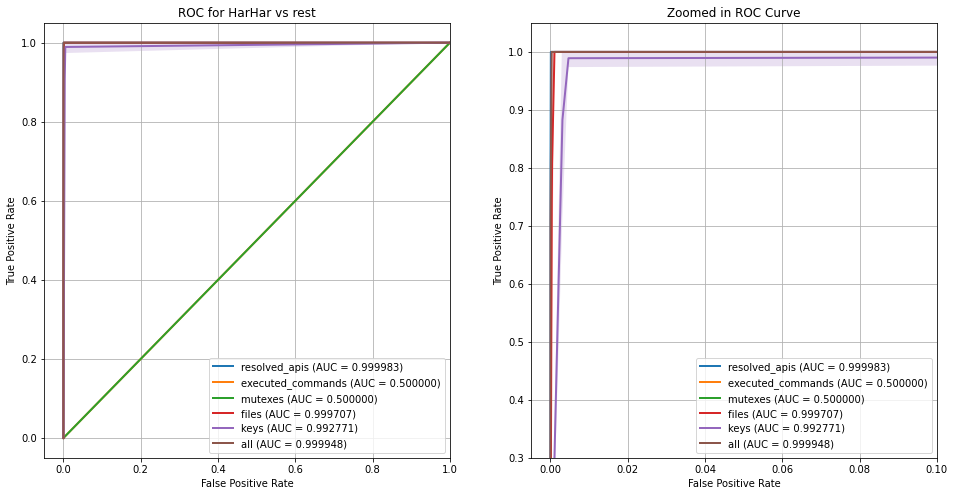

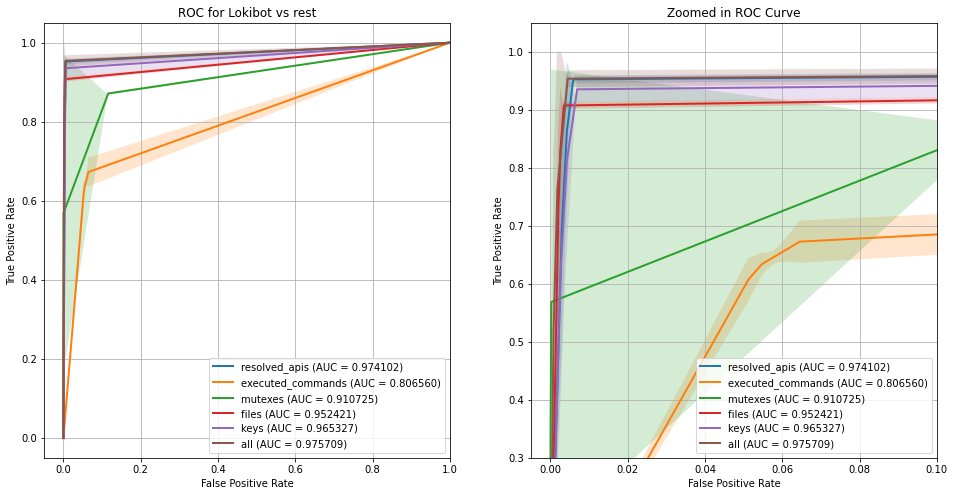

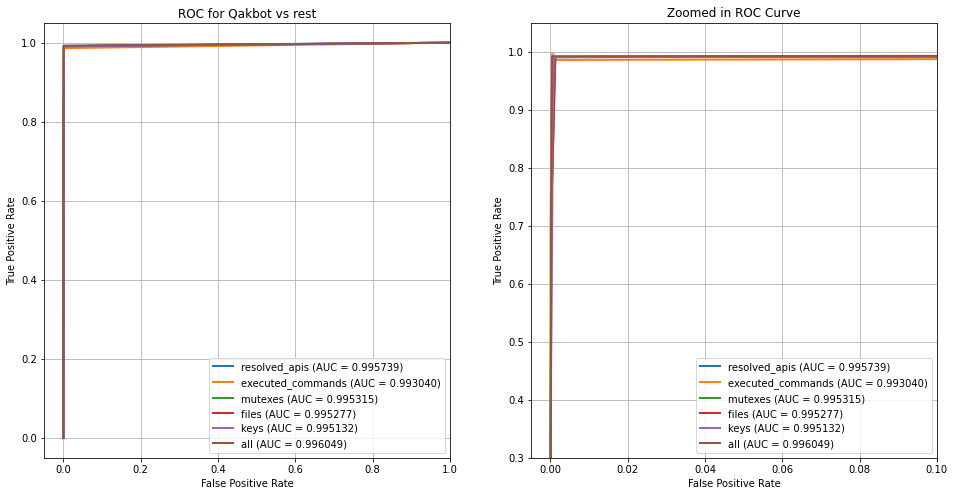

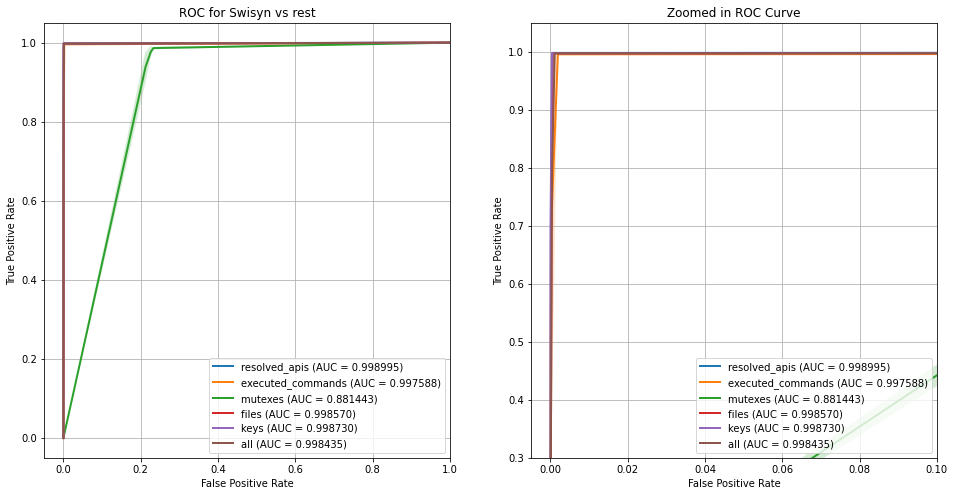

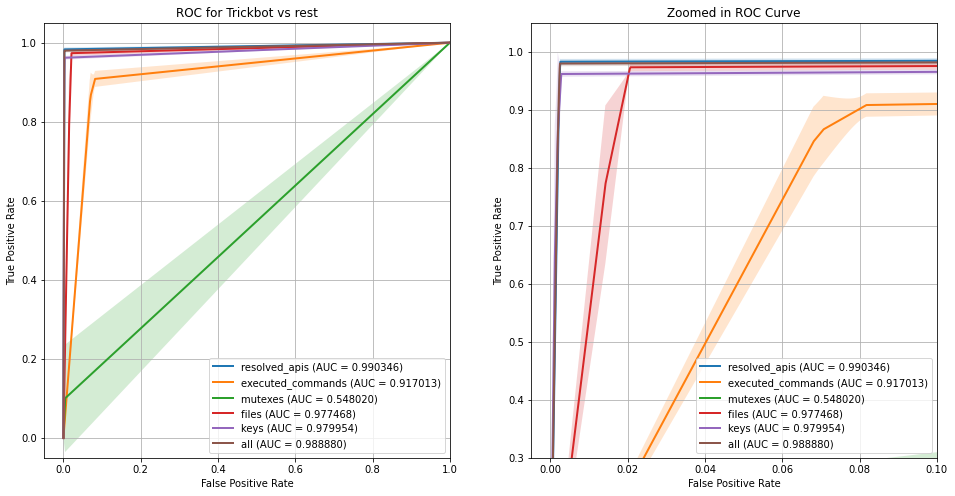

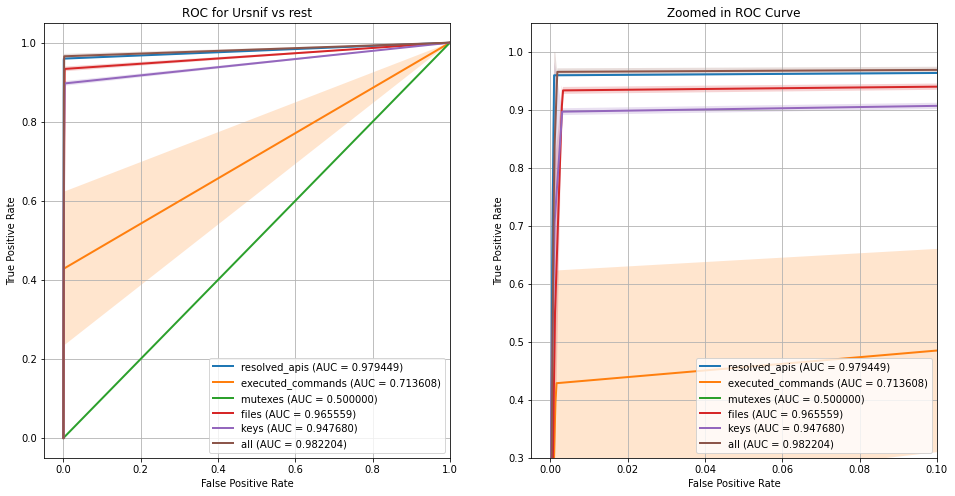

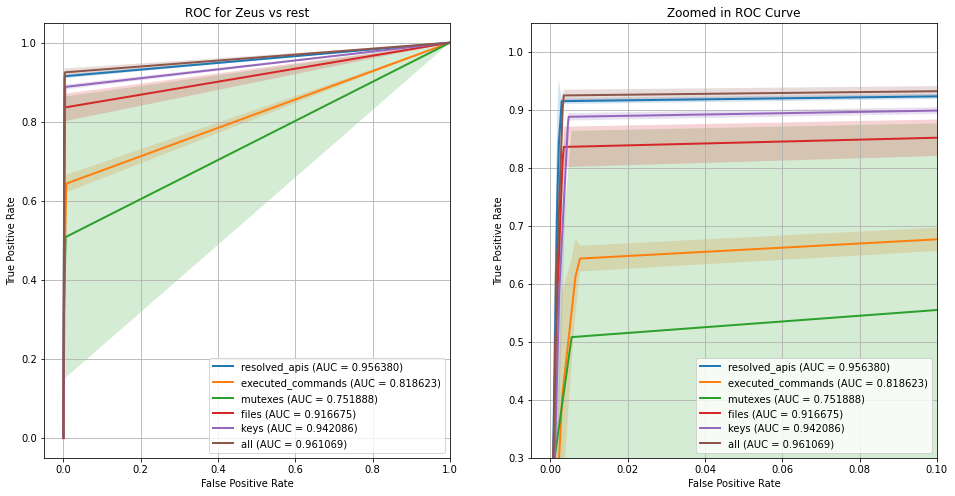

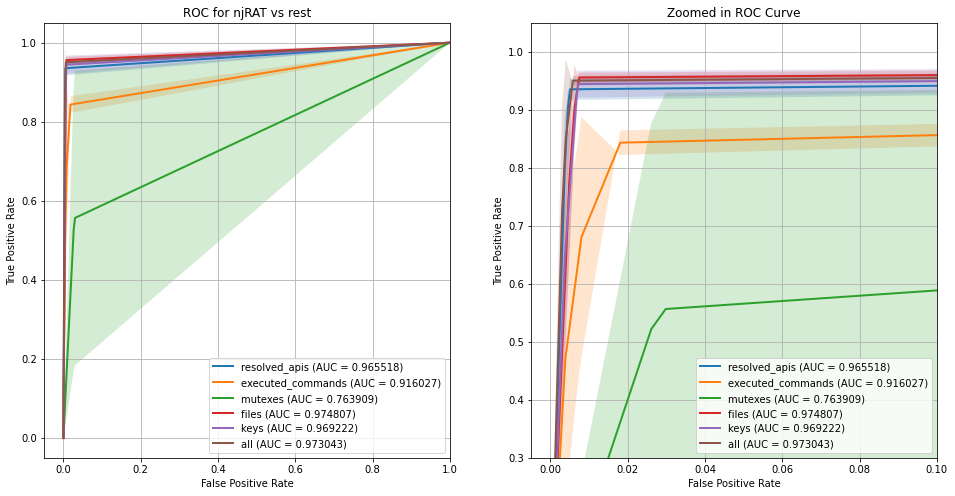

In [10]:
for selected_label in LABEL_MAP.keys():
    metrics_label = {k: v[selected_label] for k, v in metrics_test.items()}
    base_fpr_test, tprs_mean_test, tprs_std_test = allign_metrics(metrics_label)

    df, axs_test = report_alligned_metrics(
        base_fpr_test,
        tprs_mean_test,
        tprs_std_test,
        metrics_label,
        xlim=[-0.005, 0.1],
        ylim=[0.3, 1.05],
        metrics_full=True
    )
    # suptitle to refer label
    axs_test[0].set_title(f"ROC for {selected_label} vs rest")
    print(selected_label)
    print(df[df.columns[0:1].tolist() + df.columns[-5:].tolist()])